# 0.0 IMPORTS

In [1]:
import random 
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime

from IPython.display import Image
from scipy.stats import chi2_contingency
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

import xgboost as xgb
import pickle

import warnings
warnings.filterwarnings('ignore')

## 0.1 Funções auxiliares

In [2]:
def cross_validation(x_training, kfold,model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list =[]

    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))

        # Aplicando o método de cross validation para verificar a performance real dos modelos
        # Data de Início e Fim para separação das bases de validação


        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtrando o dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Conjunto de dados de treinamento e validação
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error('Model Name', np.expm1(yvalidation),np.expm1(yhat))

        # Armazenamento da performance em cada iteração da KFold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,
                        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])


def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)


def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat)/y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])        


def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max(0,chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML( '<style>.container {width:100% !important;}</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [120]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
df_sales_raw = pd.read_csv('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/dsproducao/Datasets/train.csv',low_memory=False)
df_store_raw = pd.read_csv('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/dsproducao/Datasets/store.csv',low_memory=False)

In [5]:
# Realizar a união dos datasets
# Função Merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on='Store')

In [6]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
616885,1076,4,2013-12-26,0,0,0,0,c,1,a,c,90.0,NaN,NaN,1,1.0,2013.0,"Jan,Apr,Jul,Oct"


# 1.0 DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

In [8]:
# Consulta o nome das colunas do dataset
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Renomear as colunas

In [9]:
# Transformando as colunas em Snakecase
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))

# rename
df1.columns = cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Dimensão do Dataset

In [11]:
# Verificar o tamanho do dataset
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))      

Number of rows: 1017209
Number of columns: 18


## 1.3 Tipo de dados 

In [12]:
# Consultar o tipo dos dados
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
# Transformar a data de object para date
df1['date'] = pd.to_datetime(df1['date']) 

In [14]:
# Realizar nova consulta
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Substituir valores ausentes

In [15]:
# Verificar se existe NAs no dataset
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preencher valores ausentes

In [16]:
# Preencher os valores NAs - Para preenchimento dos valores ausentes foi tratada cada coluna de forma independente, foram 
# consideradas algumas premissas, levando sempre em consideração o entendimento do negócio.

# competition_distance   
# verificando a máxima distancia até o competidor mais próximo
df1['competition_distance'].max() 
 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval

month_map = {1:'Jan', 2:'Feb', 3:'Mar',4:'Apr',5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0 , axis = 1)

In [17]:
df1.sample(5).T

,414662,923430,815427,60527,606295
store,668,996,33,318,521
day_of_week,3,2,7,7,6
date,2014-06-25 00:00:00,2013-03-26 00:00:00,2013-06-30 00:00:00,2015-06-07 00:00:00,2014-01-04 00:00:00
sales,6368,8223,0,0,4759
customers,932,882,0,0,409
open,1,1,0,0,1
promo,0,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,c,a,d,d


In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Alterar tipos de dados

In [19]:
# verificar a estrutura dos dados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [21]:
# Confirmar alterações
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Estatística descritiva

In [22]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Atributos numéricos

In [23]:
# Méticas de tendência central - Média e Mediana

ct1 = pd.DataFrame(num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame(num_attributes.apply( np.median ) ).T

# Métricas de dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply( min ) ).T
d3 = pd.DataFrame(num_attributes.apply( max ) ).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T
                  
# Concatenar
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = (['attributes','min','max','range','mean','median','std','skew','kurtosis'])               
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


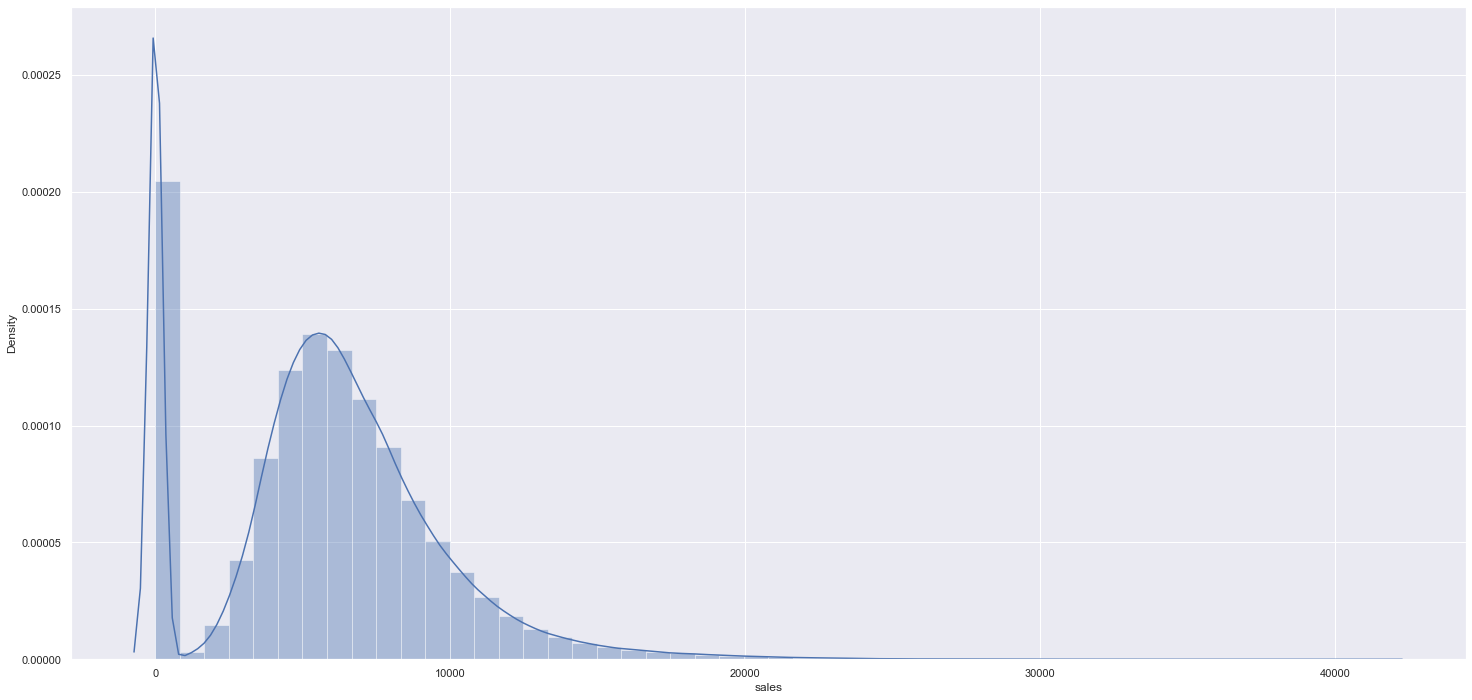

In [24]:
# Analisar vendas no histograma
sns.distplot(df1['sales']);

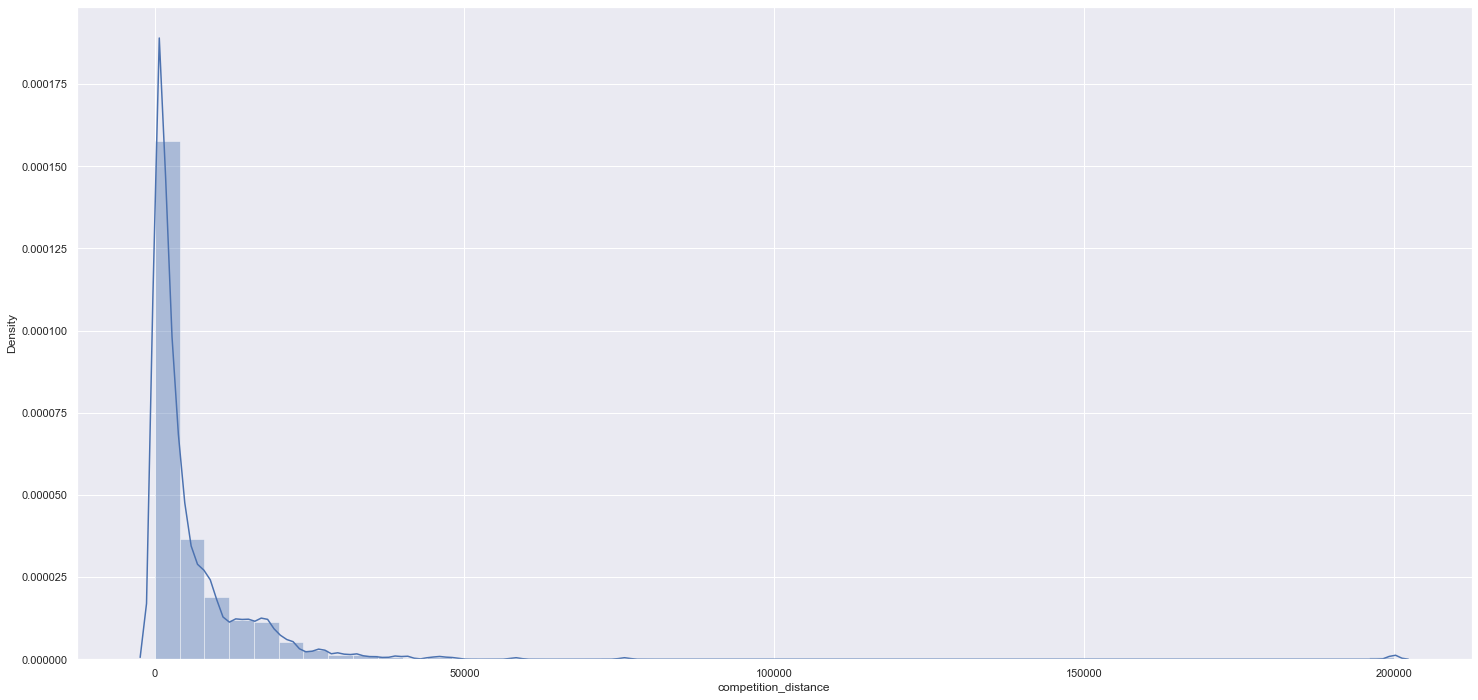

In [25]:
sns.distplot(df1['competition_distance']);

### 1.7.2 Atributos categóricos

In [26]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

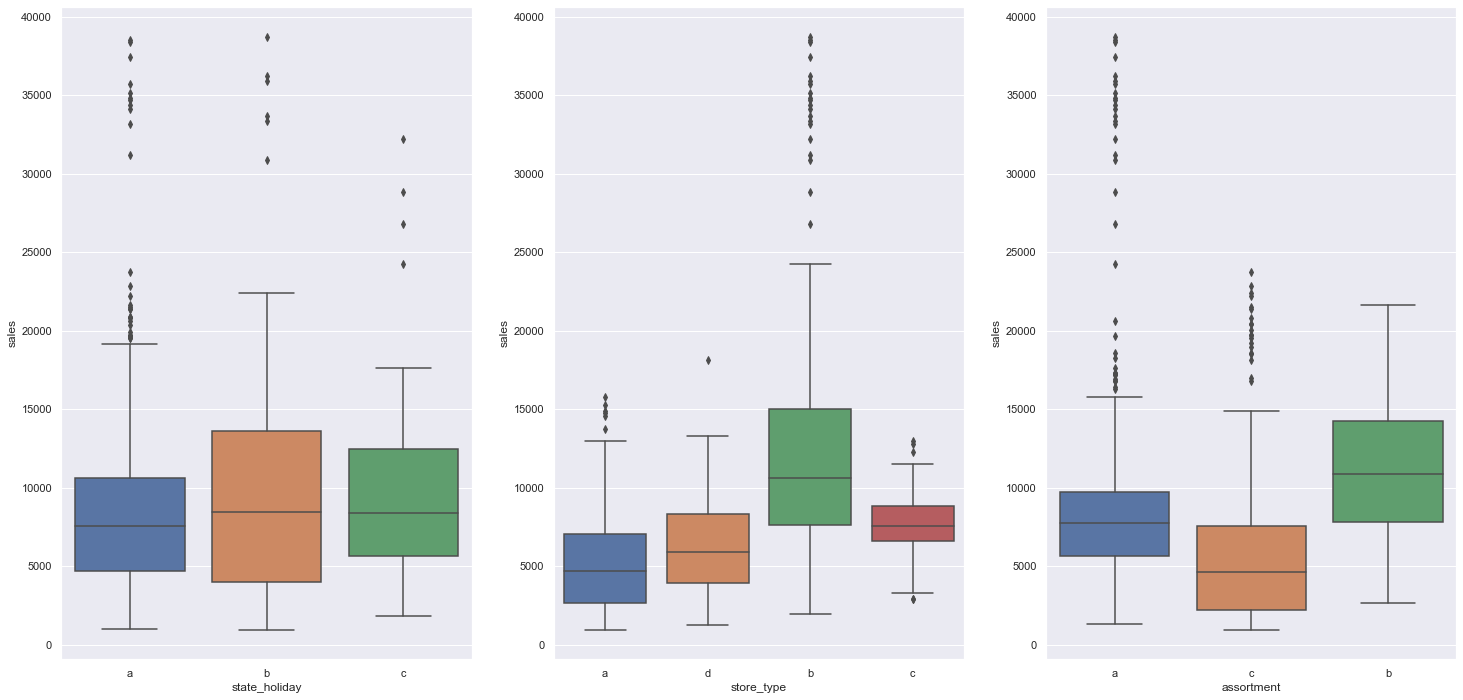

In [27]:
# Plotar boxplot para visualizar as variáveis
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Plotar 3 graficos numa única linha, sendo esse na primeira posição
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday',y='sales', data = aux1);

# Plotar 3 graficos numa linha, sendo esse na segunda posição
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type',y='sales', data = aux1);

# Plotar 3 graficos numa linha, sendo esse na terceira posição
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment',y='sales', data = aux1);

# 2.0 FEATURE ENGINEERING

In [28]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

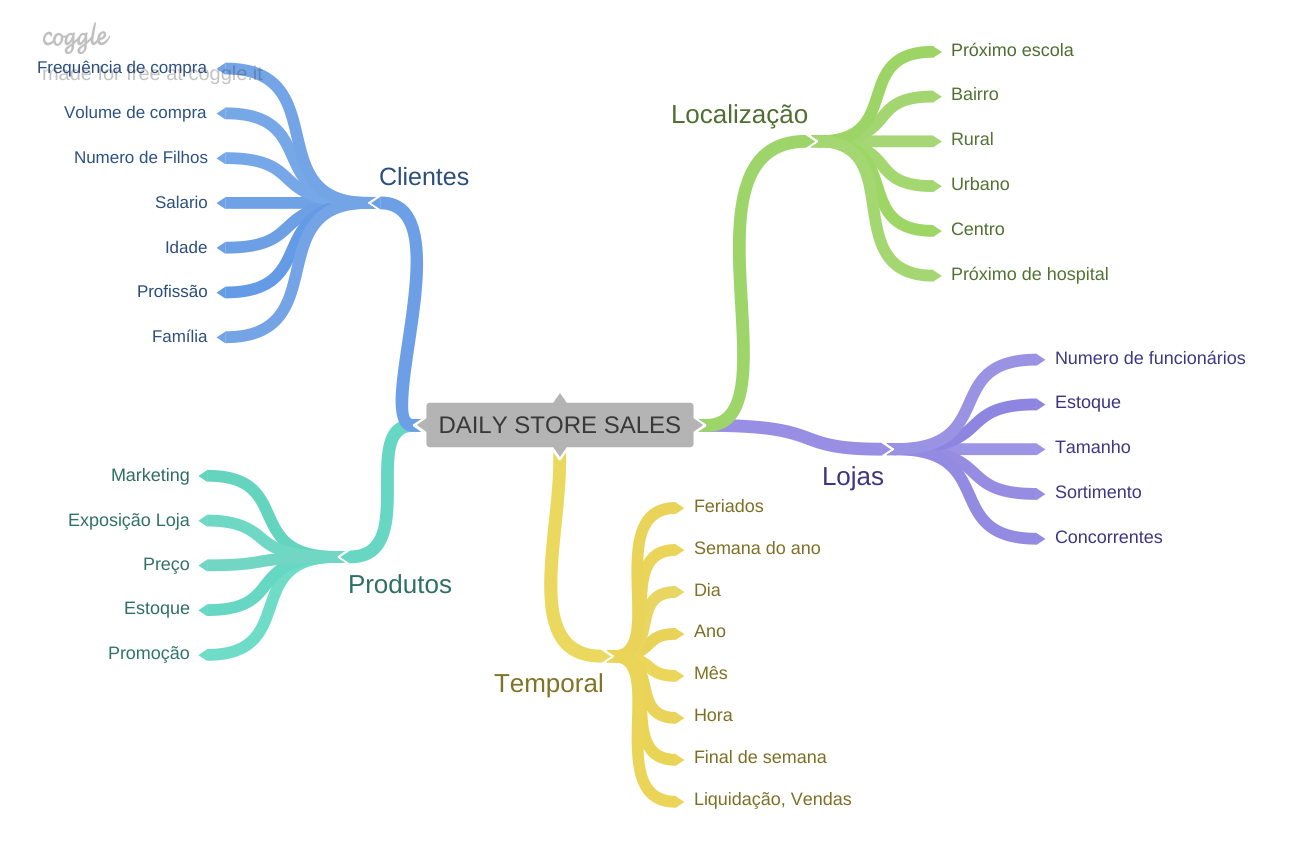

In [29]:
# Apresentação da construção do mapa de hipoteses construído para através das variáveis gerar hipoteses e insights gerando 
# para o negócio.
Image('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/dsproducao/imagem/MindMapHipothesis.png')

## 2.2 Criação das hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais. 

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista final de hipóteses

### Priorizando hipóteses

*Uma forma prática e rápida é priorizar as hipóteses levando em consideração os dados que já se possui.*

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engeneering

In [30]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since']= df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1','%Y-%W-%w' )-datetime.timedelta( days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x =='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [31]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS

In [32]:
df3 = df2.copy()

In [33]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [34]:
# Na etapa de filtragem de variáveis são consideradas as restrições de acordo com o negócio
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [35]:
# Na etapa de seleção de variáveis, são consideradas as variáveis mais relevantes ao modelo.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [36]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [37]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

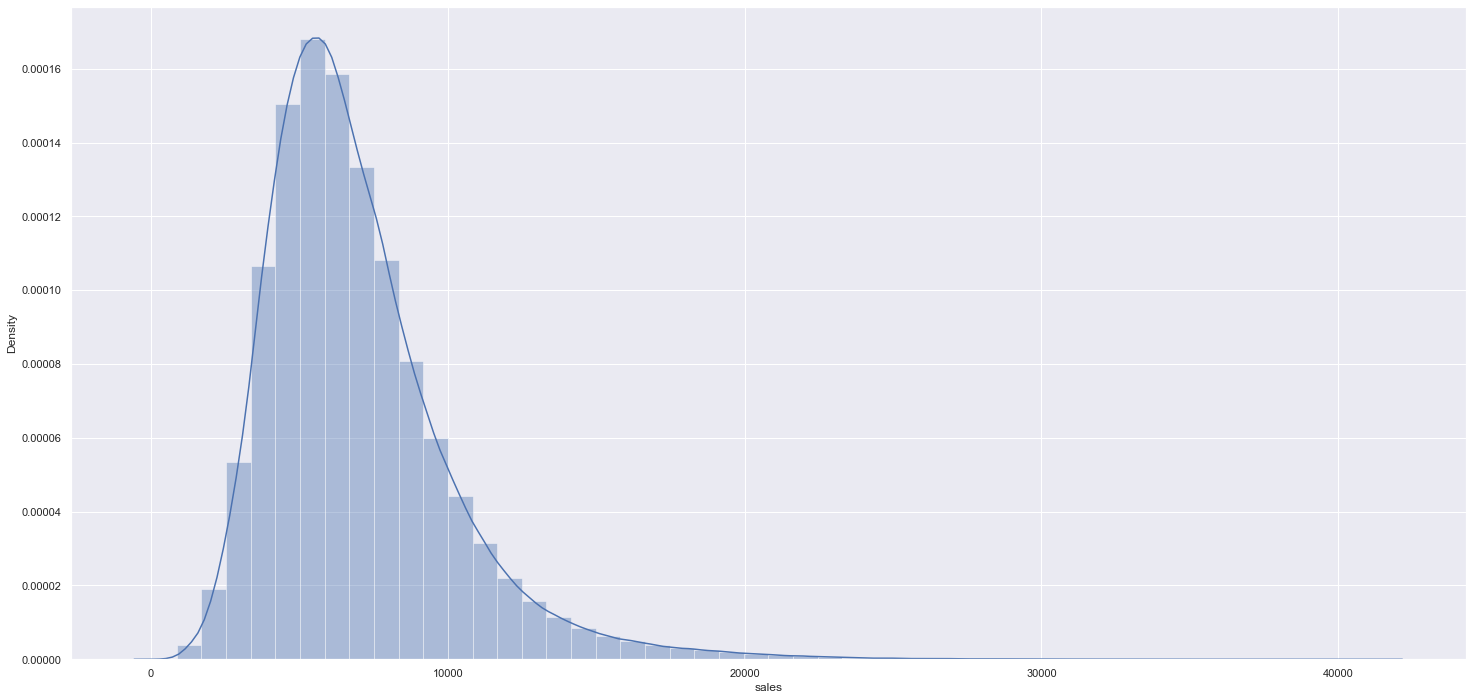

In [38]:
# Verificar distribuição do dados da variável Sales
sns.distplot(df4['sales']);

### 4.1.2 Variável Numérica

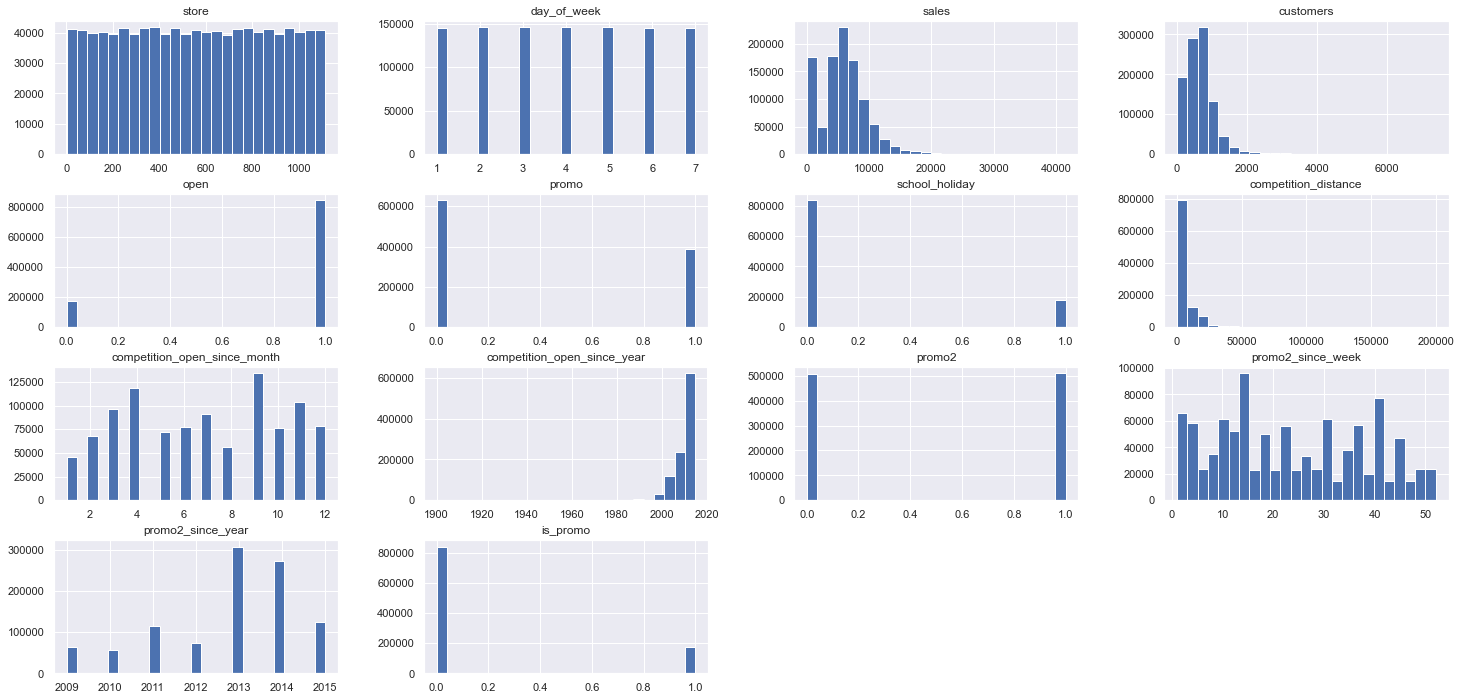

In [39]:
# Analisar variáveis númericas
num_attributes.hist(bins=25);

### 4.1.3 Variável Categórica

In [40]:
# Analisar variáveis categóricas
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [41]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

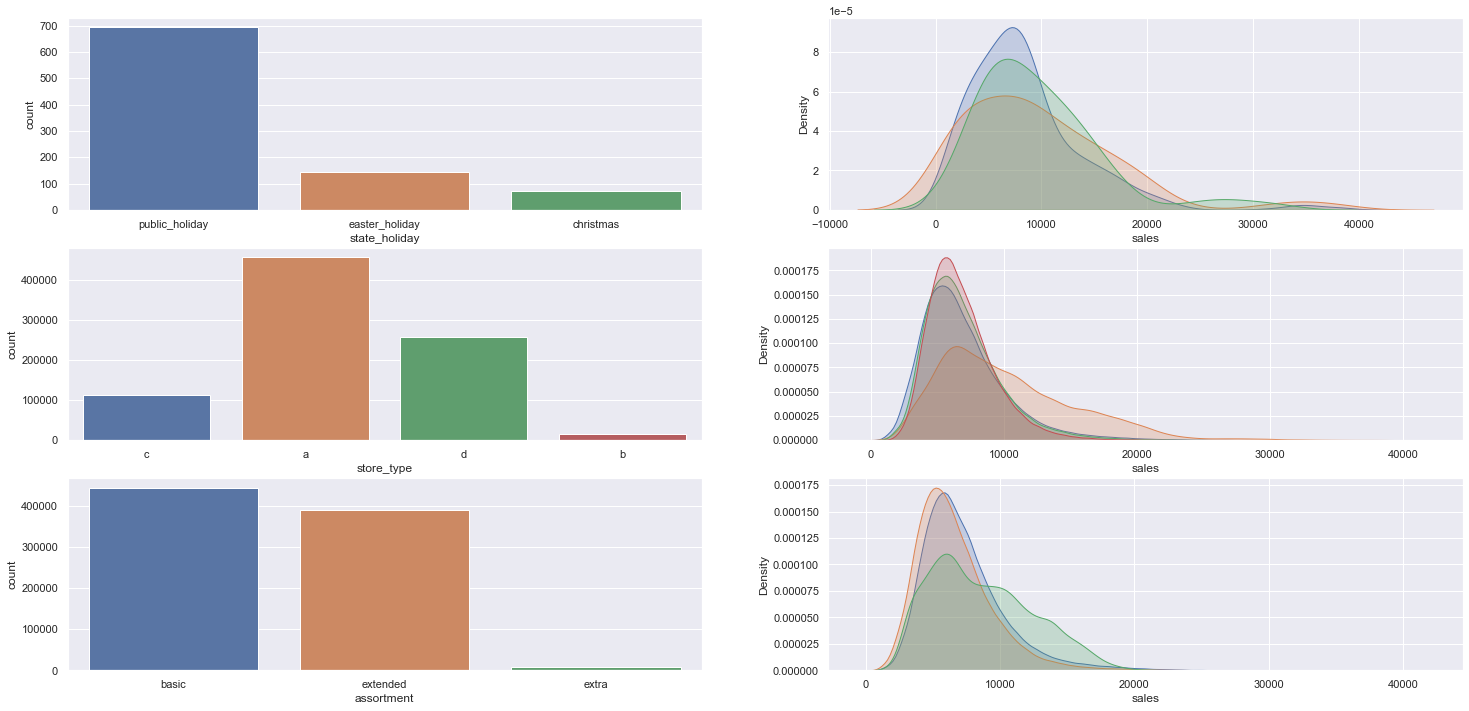

In [42]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label= 'public_holiday',shade= True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label= 'easter_holiday',shade= True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label= 'christmas',shade= True);

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label= 'a',shade= True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label= 'b',shade= True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label= 'c',shade= True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label= 'd',shade= True);

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label= 'extended',shade= True);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label= 'basic',shade= True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label= 'extra',shade= True);

## 4.2 Análise Bivariada


### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA**  Lojas com MAIOR SORTIMENTO vendem MENOS.

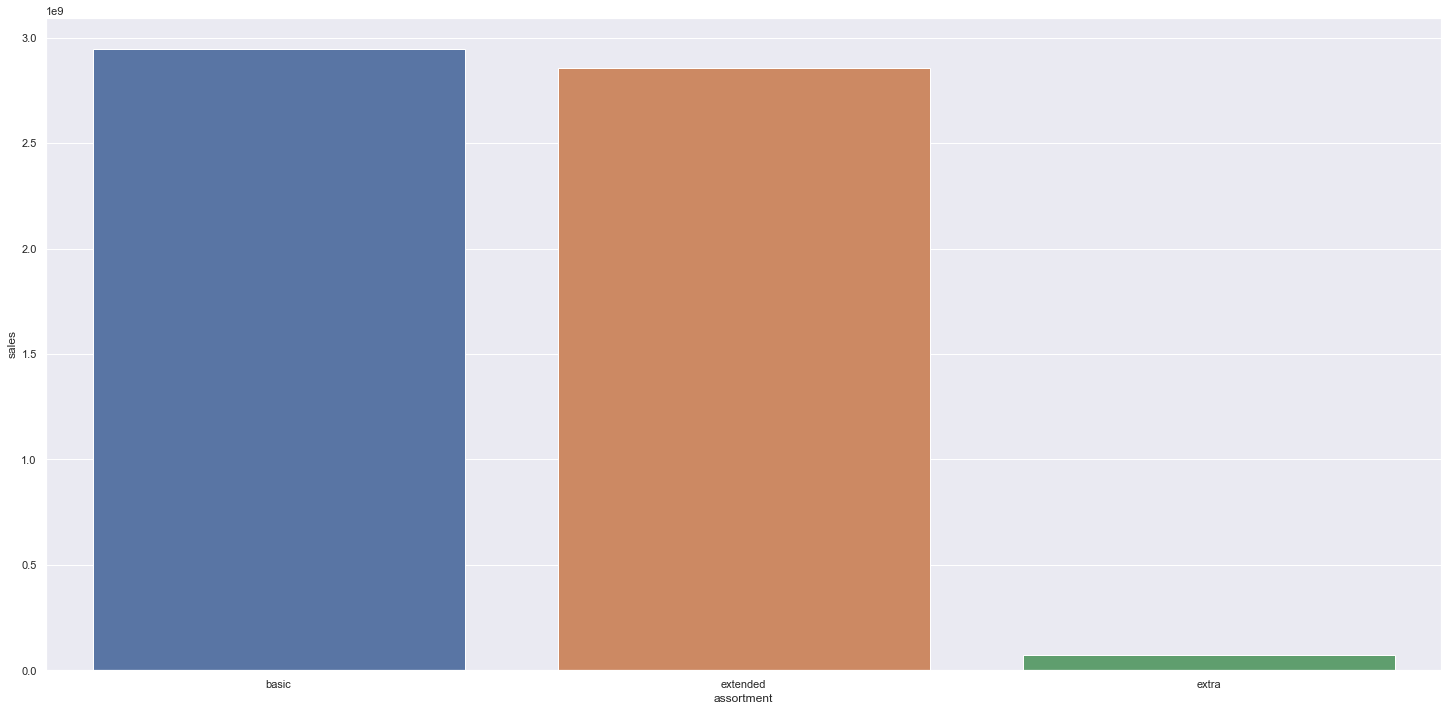

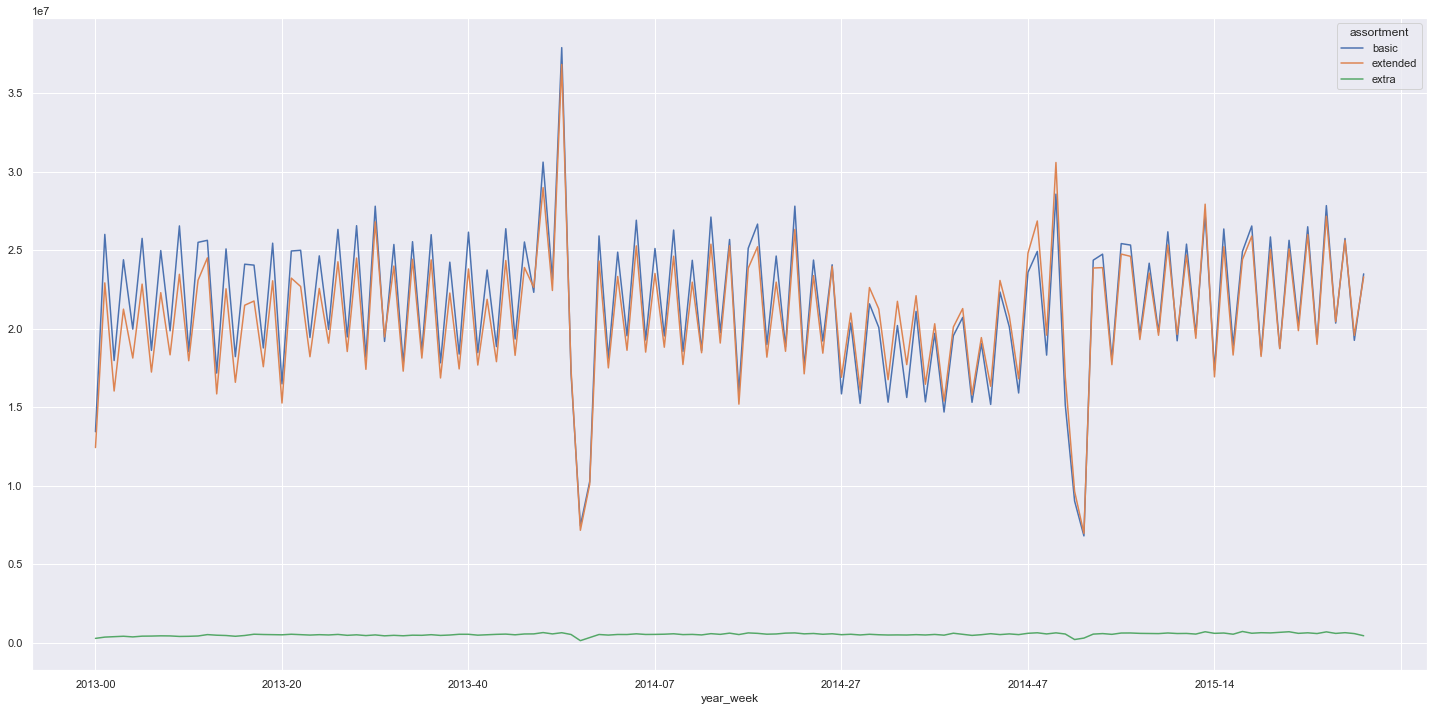

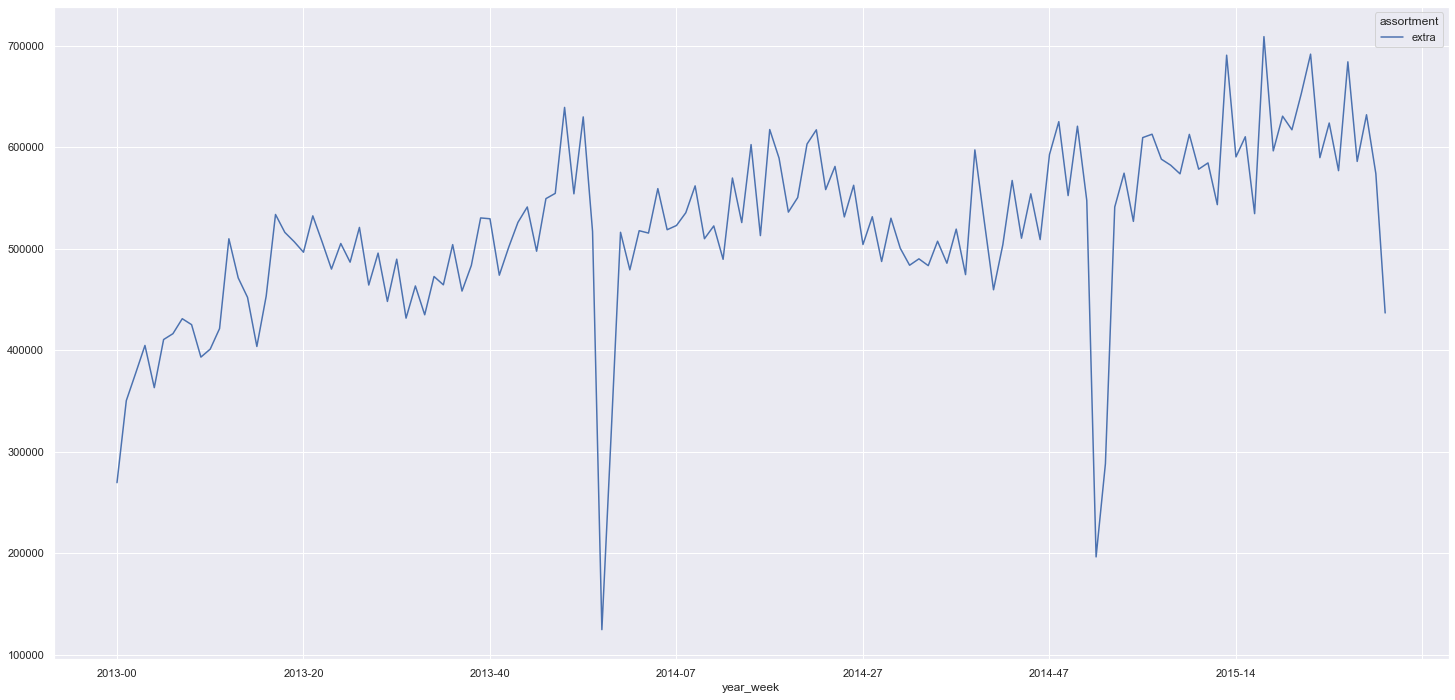

In [43]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA**  Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

(2.5, -0.5)

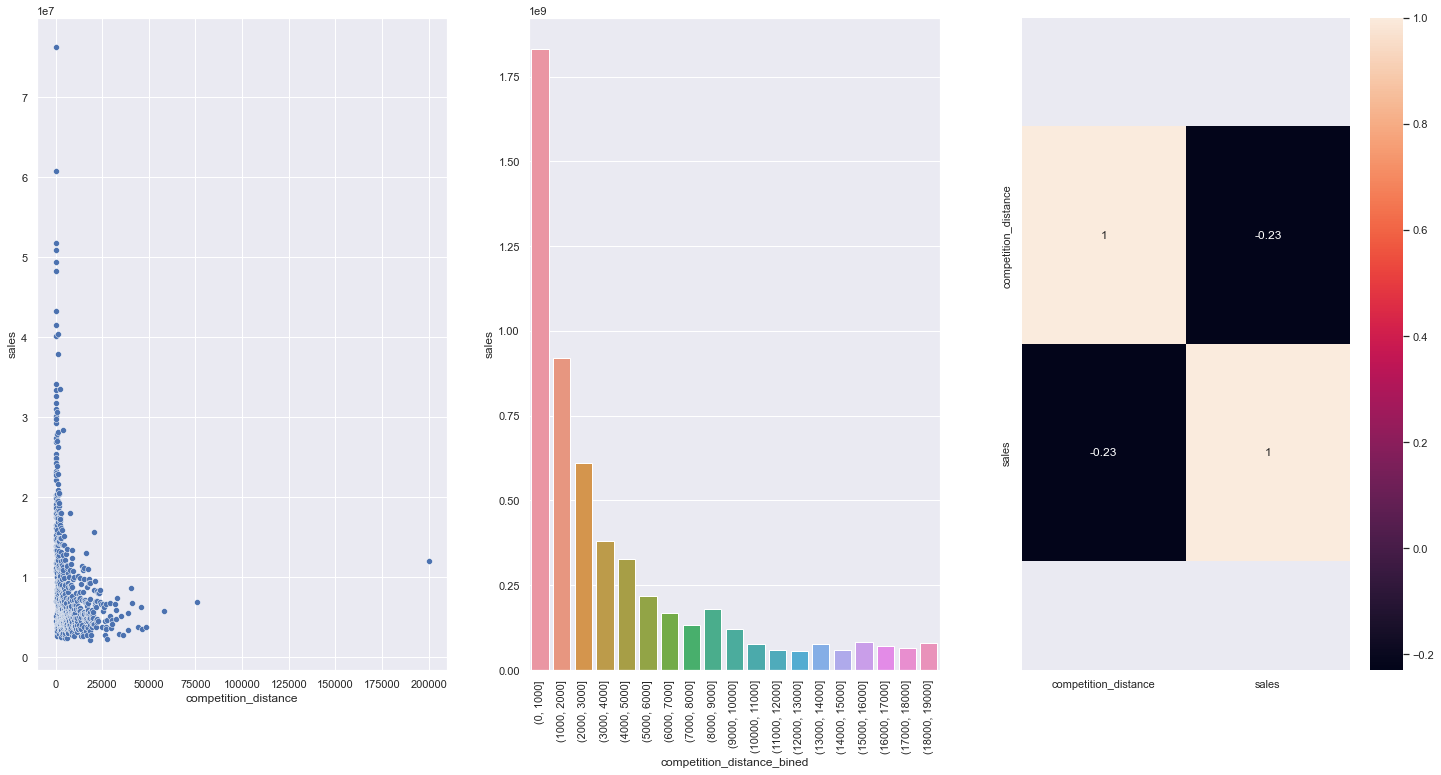

In [44]:
aux1 = df4[['competition_distance','sales']].groupby(['competition_distance']).sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins= list(np.arange(0,20000,1000))
aux1['competition_distance_bined'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby(['competition_distance_bined']).sum().reset_index()
sns.barplot(x='competition_distance_bined', y='sales', data=aux2);
plt.xticks(rotation=90);


plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5)

In [45]:
aux1.head()

,competition_distance,sales,competition_distance_bined
0,20.0,4579807,"(0, 1000]"
1,30.0,17552666,"(0, 1000]"
2,40.0,29261626,"(0, 1000]"
3,50.0,60835848,"(0, 1000]"
4,60.0,22088359,"(0, 1000]"


### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSA**  Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

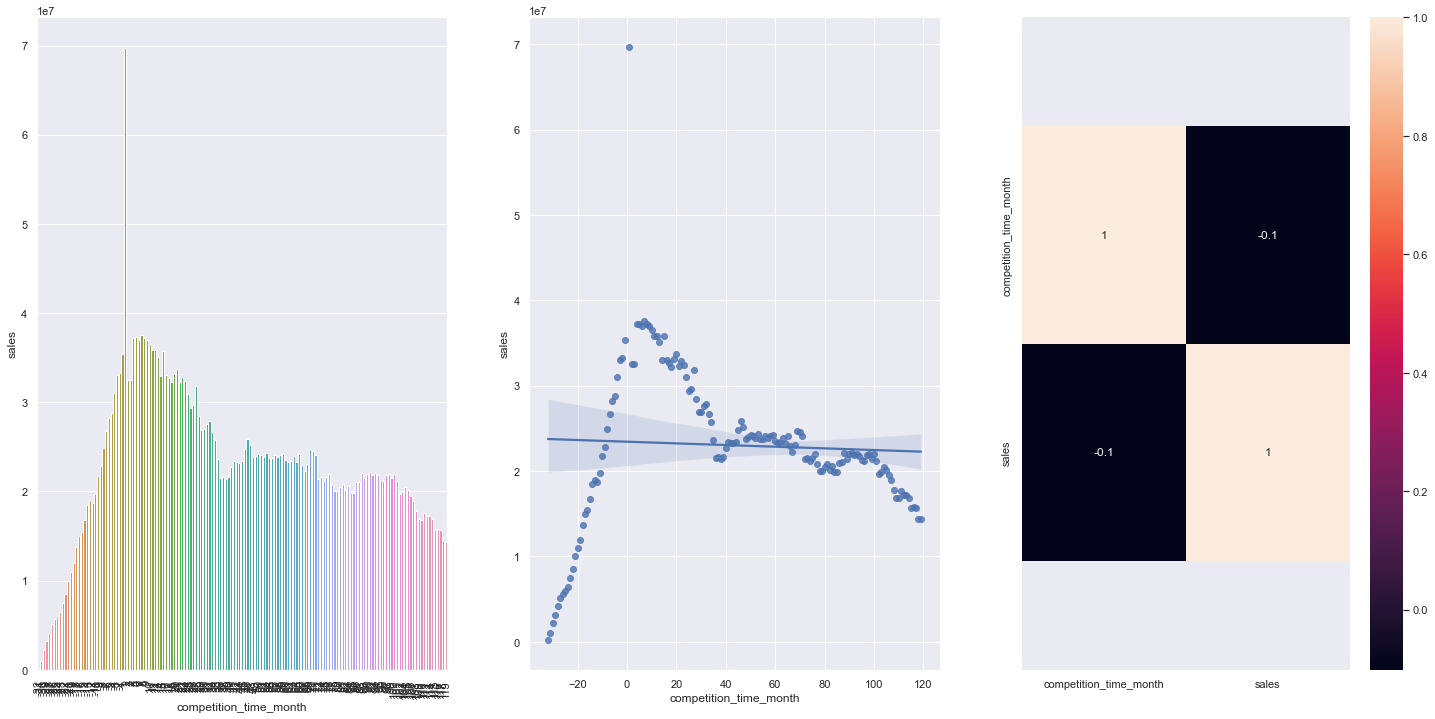

In [46]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### **H4.**Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA**  Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS, depois de um certo período de promoção.

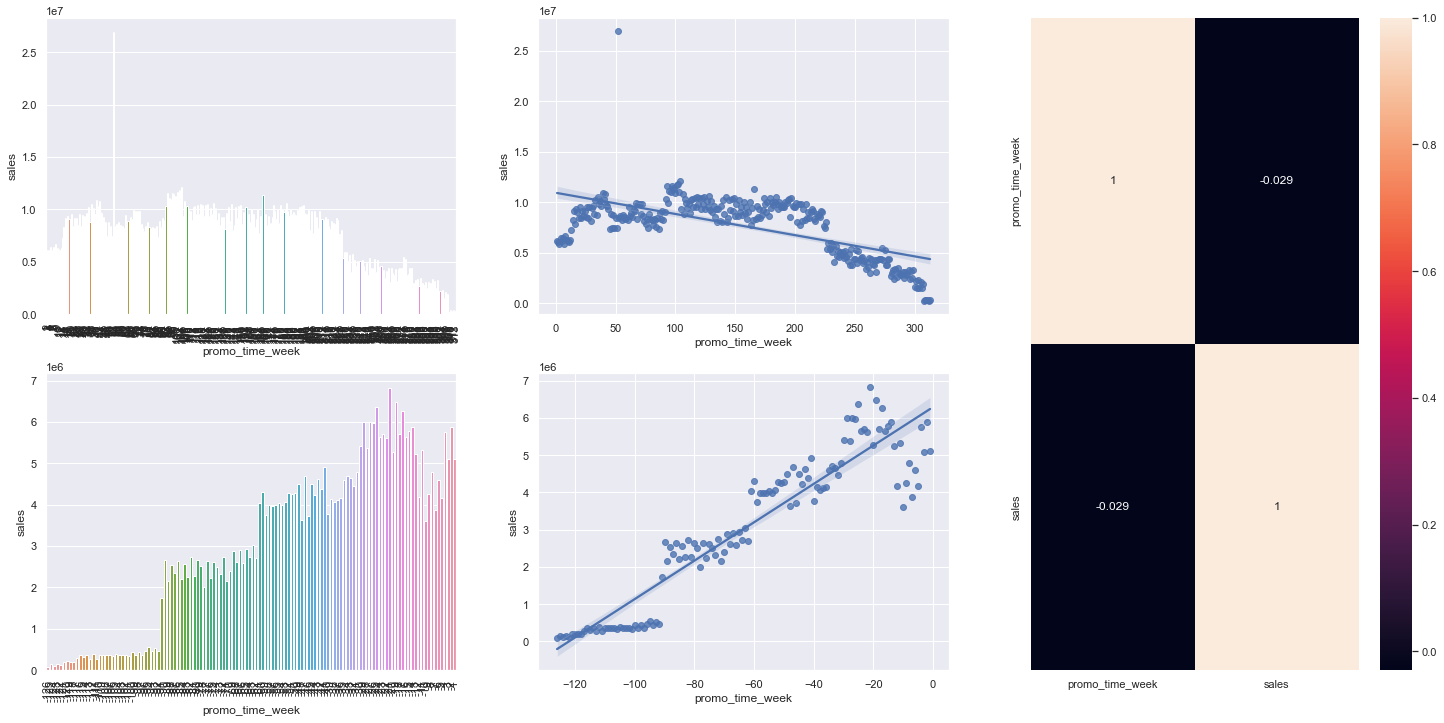

In [47]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # promo extendido
sns.barplot(x ='promo_time_week', y ='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x ='promo_time_week', y ='sales', data=aux2);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0]
sns.barplot(x ='promo_time_week', y ='sales', data=aux3);
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x ='promo_time_week', y ='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA**  Lojas com MAIS PROMOÇÕES CONSECUTIVAS vendem MENOS.

In [48]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


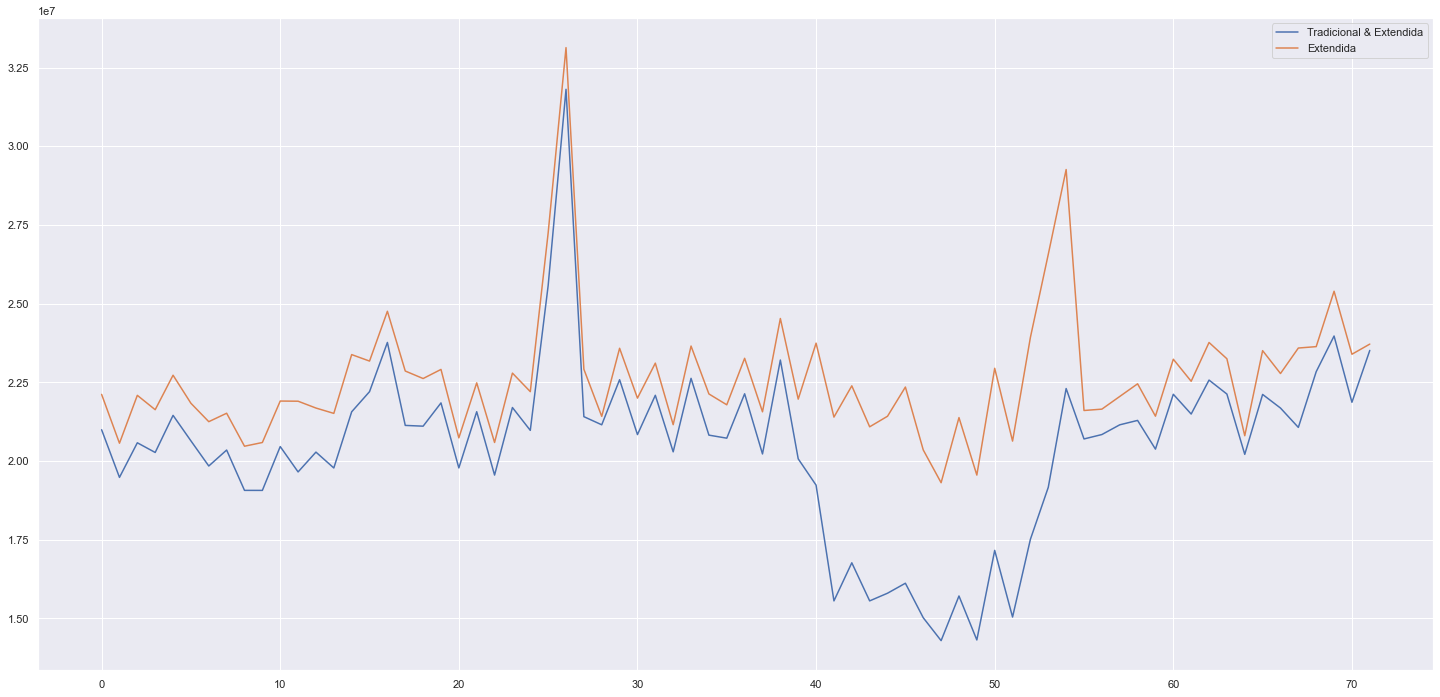

In [49]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax2 = aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA**  Lojas ABERTAS DURANTE O FERIADO DE NATAL vendem MENOS.

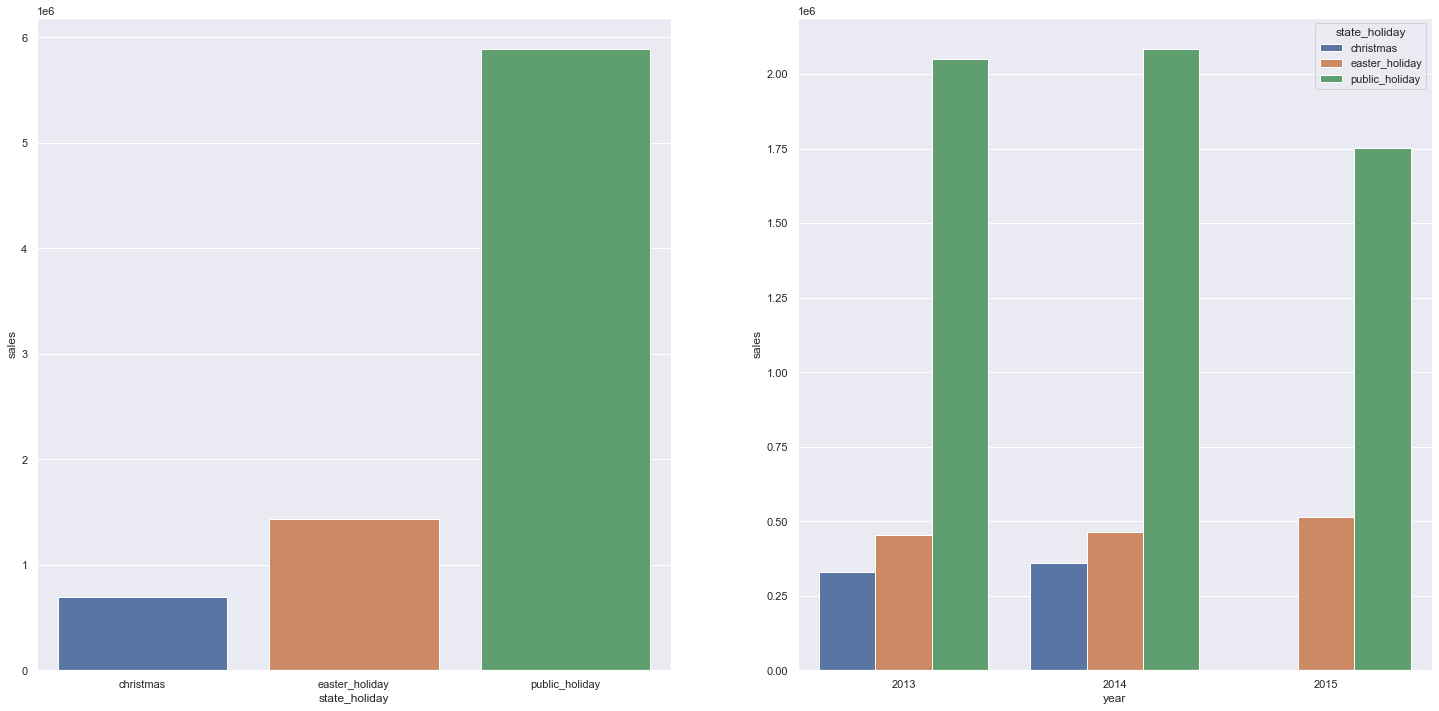

In [50]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 =aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales', hue='state_holiday',data=aux2);

### **8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas VENDEM MENOS AO LONGO DOS ANOS.

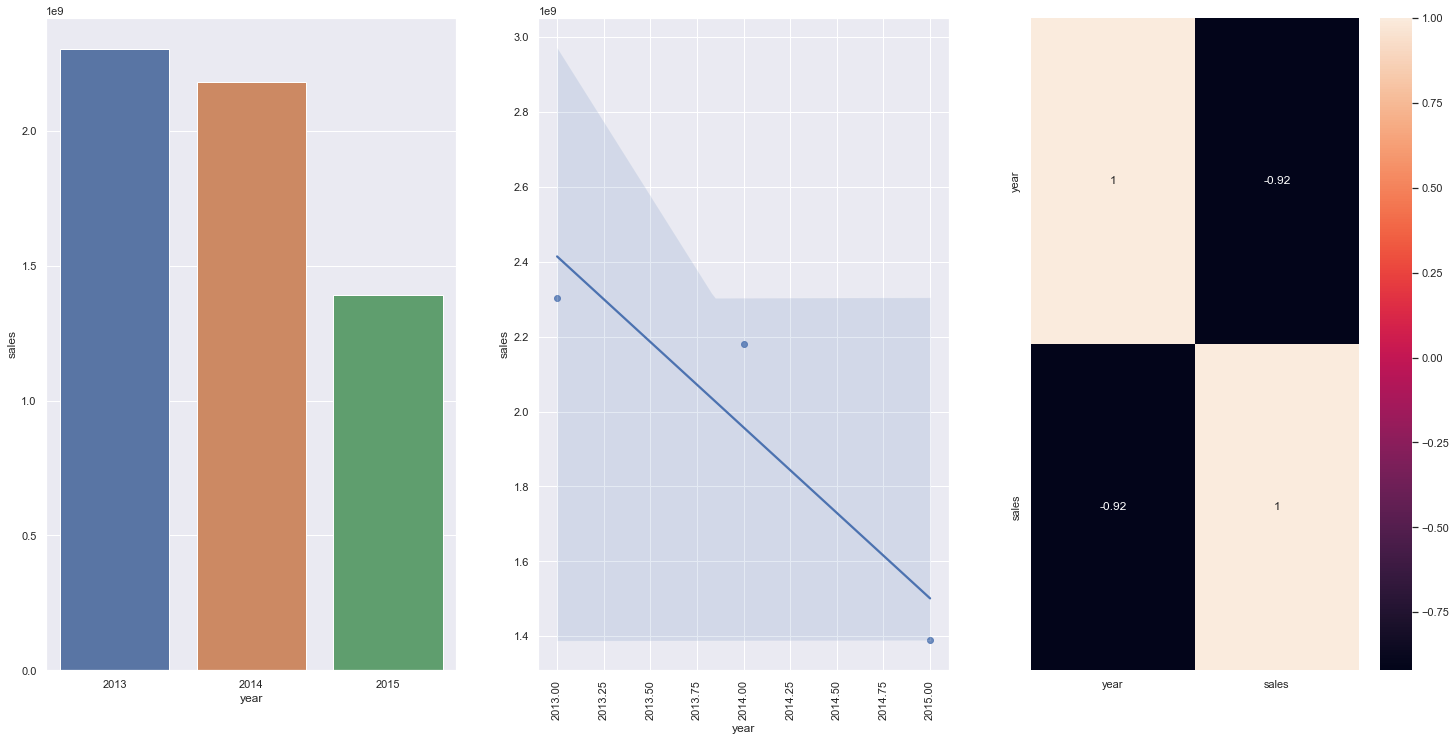

In [51]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales', data=aux1);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas VENDEM MENOS NO SEGUNDO SEMESTRE DO ANO.

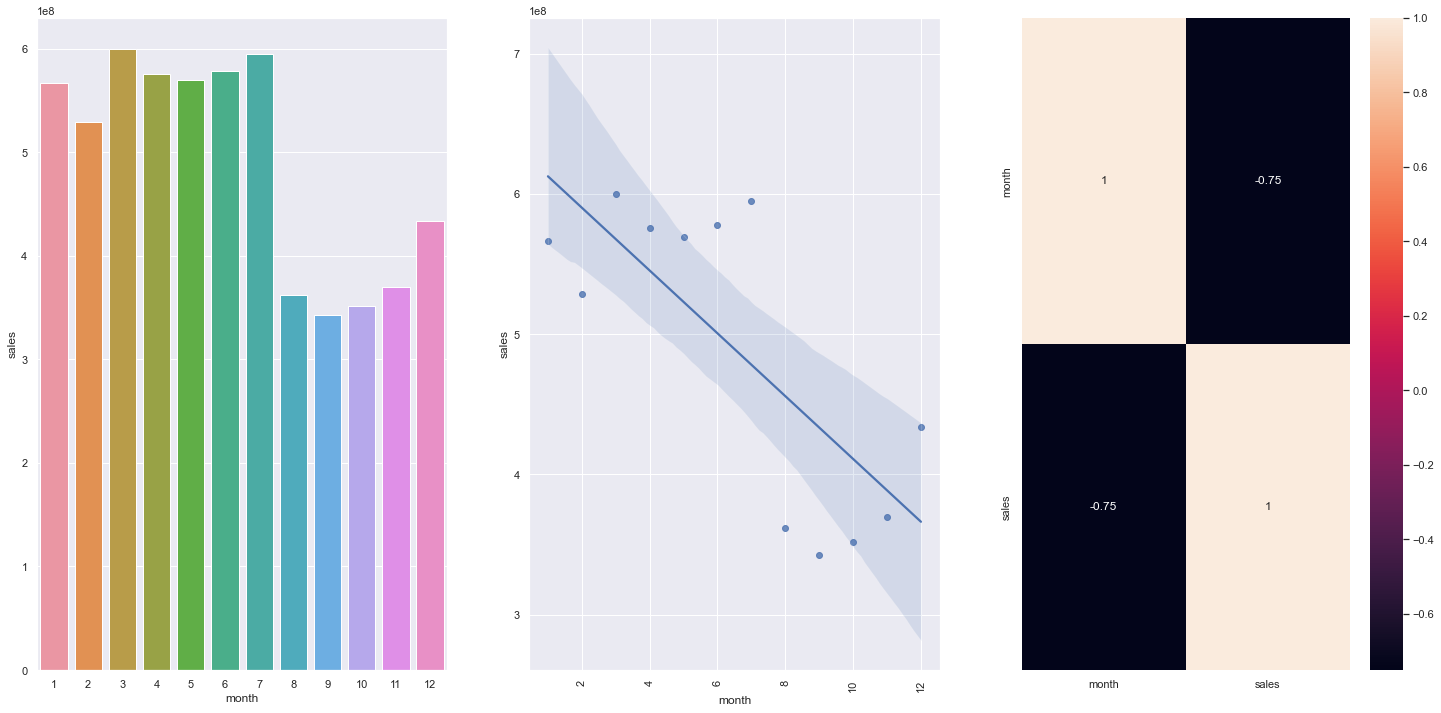

In [52]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales', data=aux1);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas VENDEM MAIS depois do DIA 10 de cada MÊS.

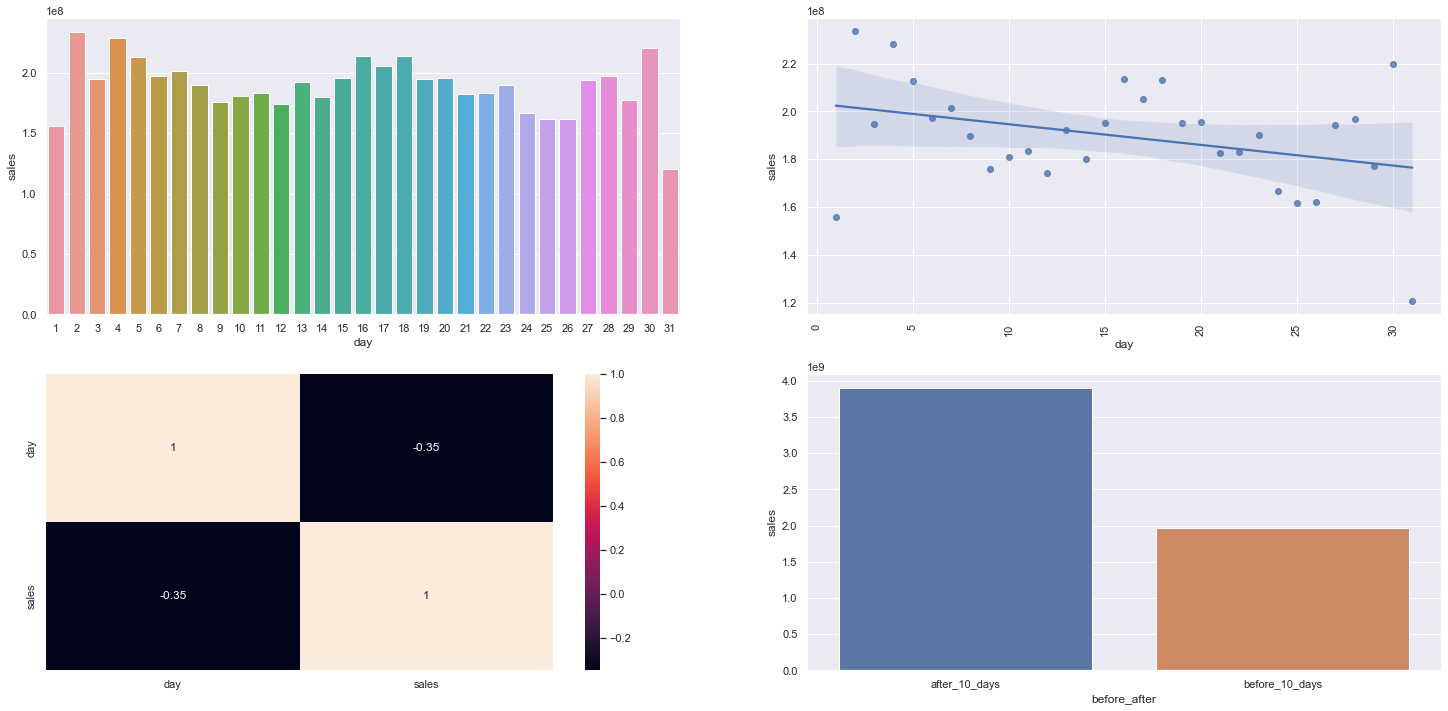

In [53]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales', data=aux1);
plt.xticks(rotation=90)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux2=aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales', data=aux2);

### **11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas VENDEM MENOS aos FINAIS DE SEMANA.

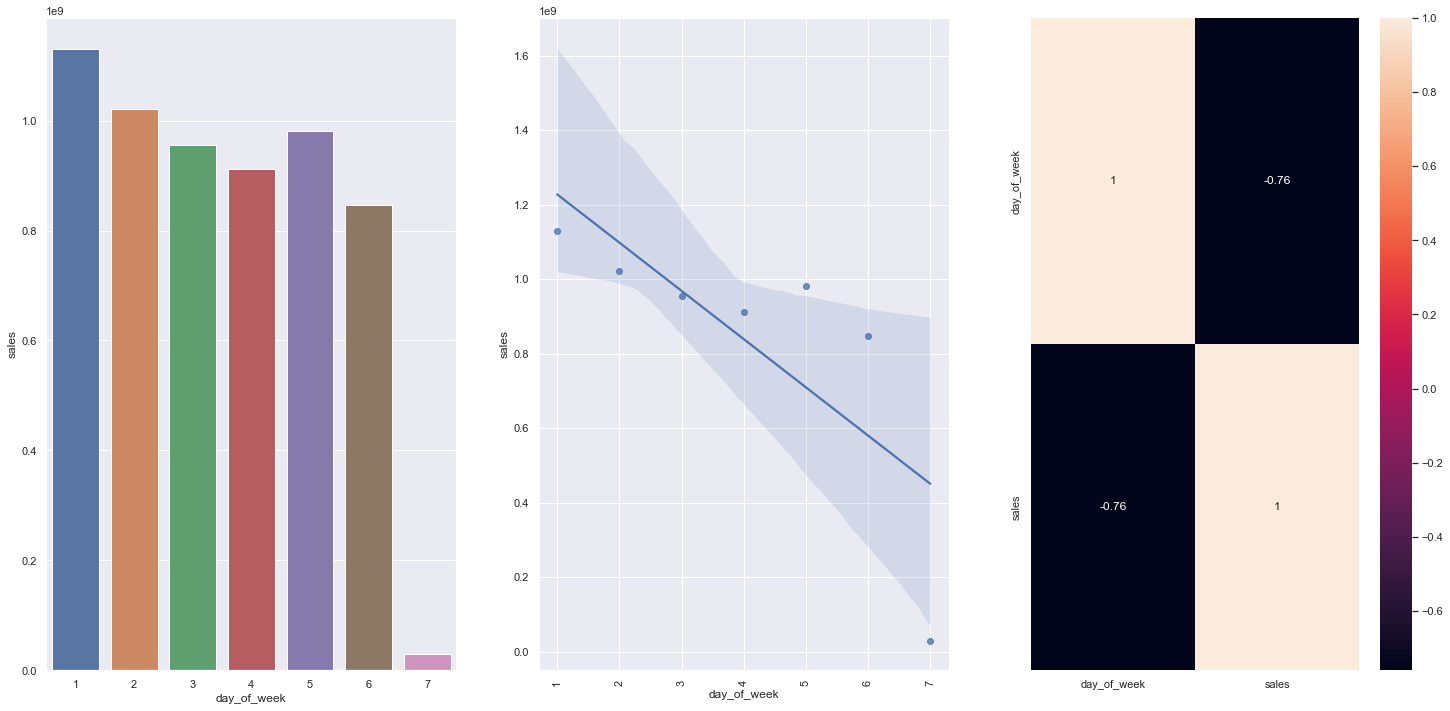

In [54]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales', data=aux1);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas VENDEM MENOS durante os feriados escolares, EXCETO OS MESES DE JULHO E AGOSTO.

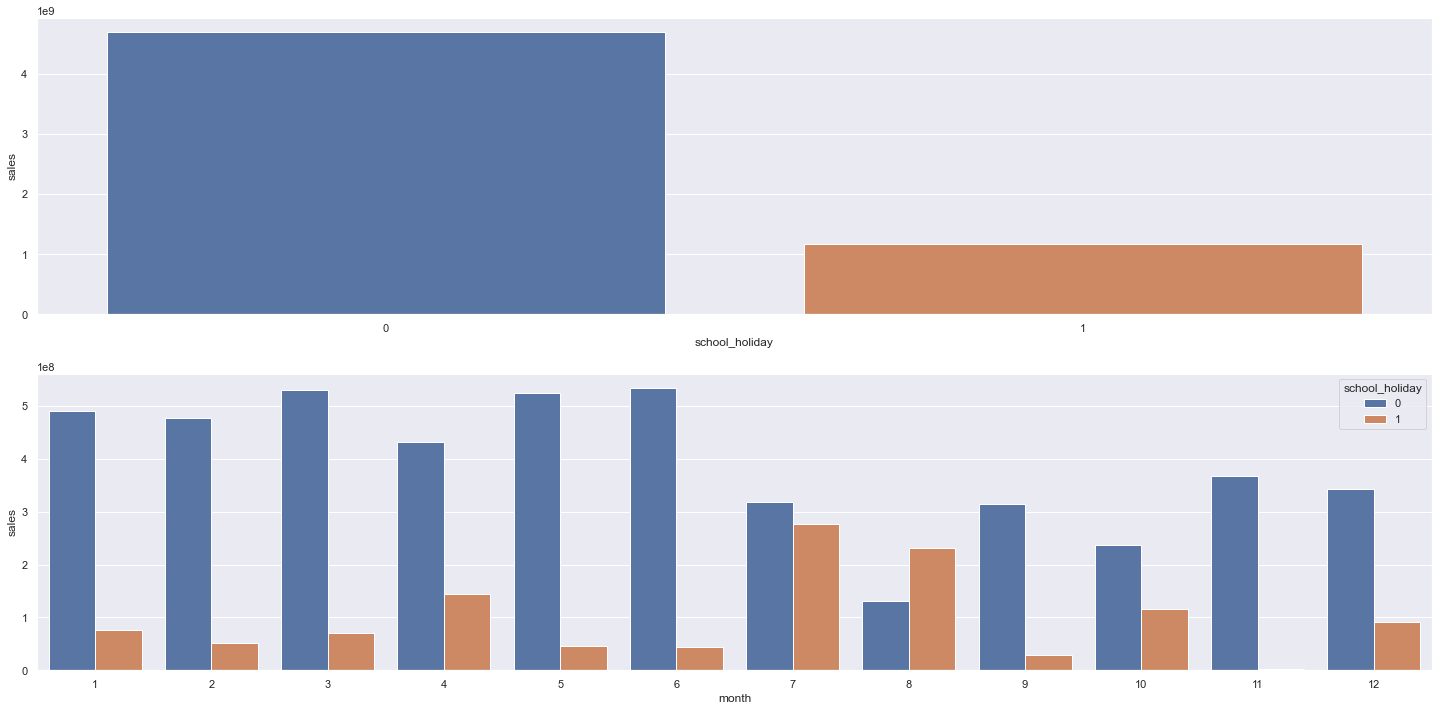

In [55]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales', hue='school_holiday',data=aux2);

### 4.2.1 Resumo das hipóteses

In [56]:
from tabulate import tabulate

In [57]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa']
]
print(tabulate(tab, headers='firstrow') )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos


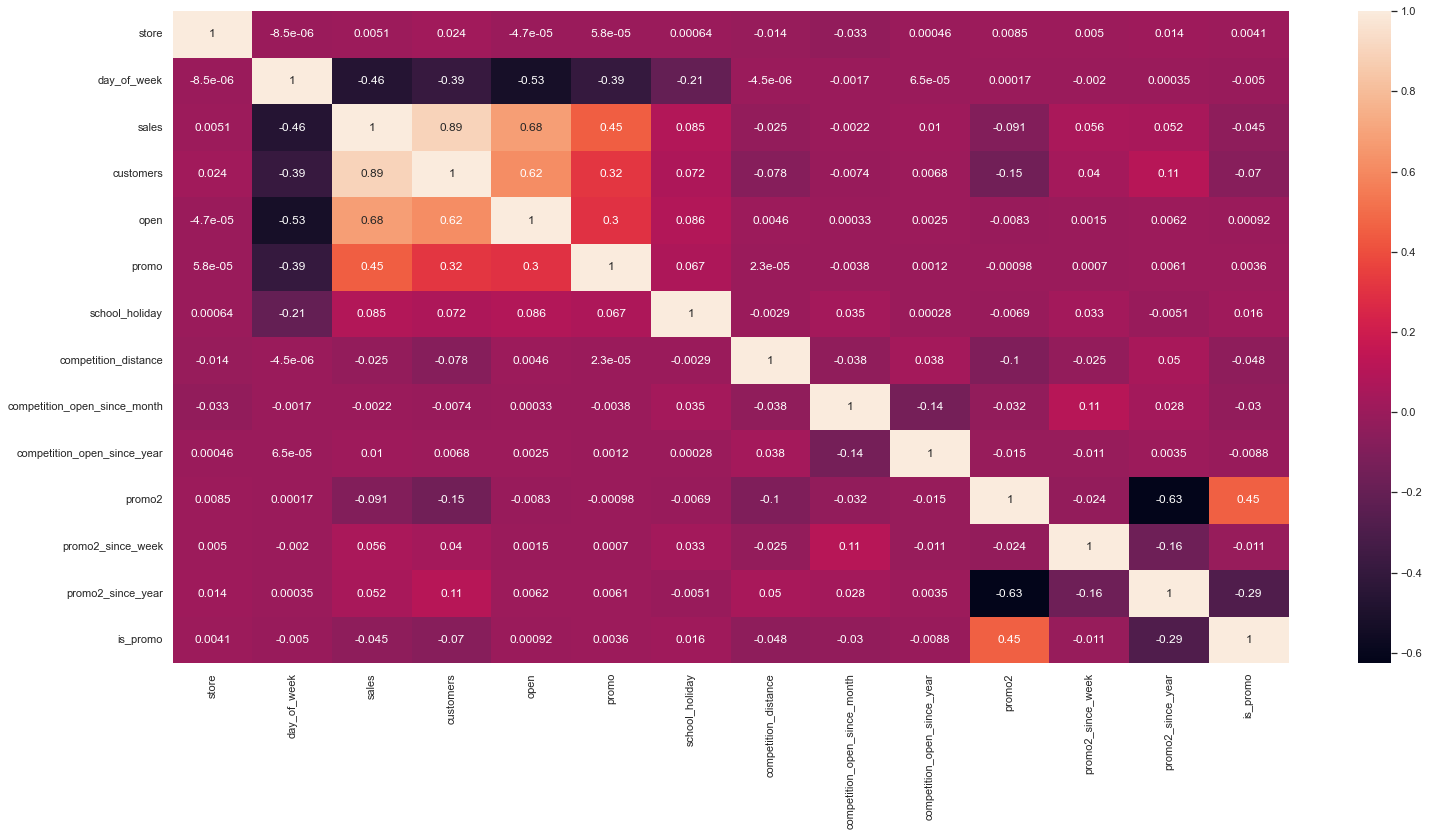

In [58]:
# Aplicar o método de Pearson, utiliado para verificar a correlação entre variáveis numéricas. 
# Verificar a correlação de todas as variáveis númericas do dataset.
sns.heatmap(num_attributes.corr(method='pearson'),annot=True);

### 4.3.2 Atributos categóricos

In [59]:
# Aplicar o método V de Cramér que é uma medida de associação entre duas variáveis nominais. 
# Fornece um valor entre 0 e +1 esse método é baseado na estatística qui-quadrado de Pearson.
# Criar função para utilizar mais vezes.

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = chi2_contingency( cm )[0]
    chi2corr = max(0,chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

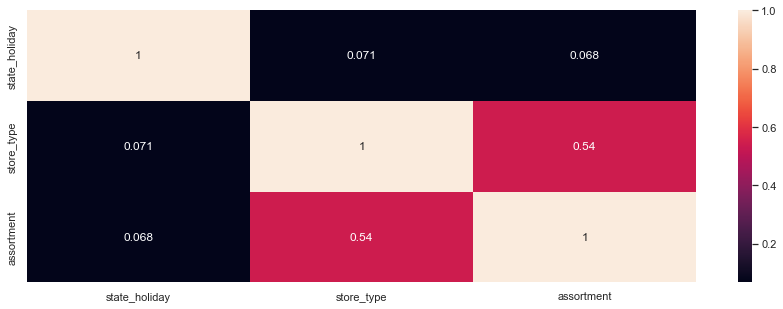

In [60]:
# Somente seleção para categoria de tipo de dados
a = df4.select_dtypes(include='object')

# Cálculando cramer_v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

# Dataset Final
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
                  'store_type':[a4,a5,a6],
                  'assortment':[a7,a8,a9] })    

d = d.set_index(d.columns)

sns.set(rc={'figure.figsize':(15,5)})

sns.heatmap(d, annot=True);

# 5.0 PREPARAÇÃO DOS DADOS

In [61]:
df5 = df4.copy()

## 5.1 Normalização

In [62]:
# Não será realizada nenhuma normalização, pois os dados não se aproximam de dados com distribuição normal.
# Visualizar as ditribuições na seção 4.1.2 Variável Numérica

## 5.2 Rescaling

In [63]:
# Aplicar rescaling para as variáveis que não tenham uma Distribuição Gausiana (range muito grande dos valores)
# MinMaxScaler é o método utilizado para rescaling de dados que não são sensíveis a outliers
# RobustScaler é método utilizado para rescaling de dados que não contenham outliers

rs = RobustScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open ('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open ('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/competition_time_month_scaler.pkl', 'wb'))


mms = MinMaxScaler()

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open ('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/promo_time_week_scaler.pkl', 'wb'))


# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open ('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/year_scaler.pkl', 'wb'))

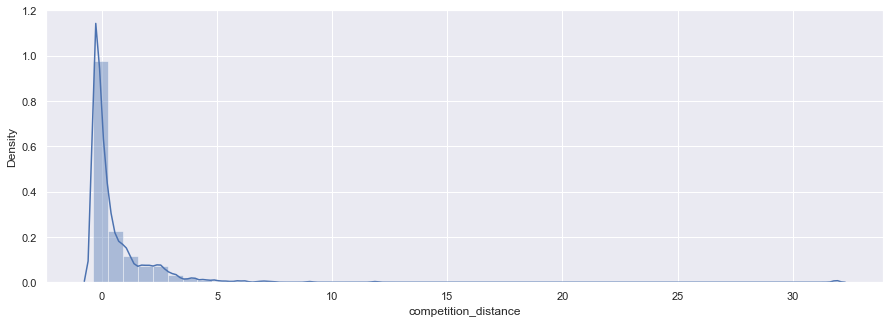

In [64]:
# Visualizar uma das variáveis para verificar a distribução após aplicada a técnica de rescaling
sns.distplot(df5['competition_distance']);

## 5.3 Transformação

### 5.3.1 Encoding

In [65]:
# state_holiday - Utilizado o One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Utilizado o Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/store_type_scaler.pkl', 'wb'))


# assortment - Utilizado o Ordinal Encoding
assortment_dict= {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação da variável resposta

In [66]:
# Aplicando transformação logarítmica na variável resposta
df5['sales']= np.log1p(df5['sales'])

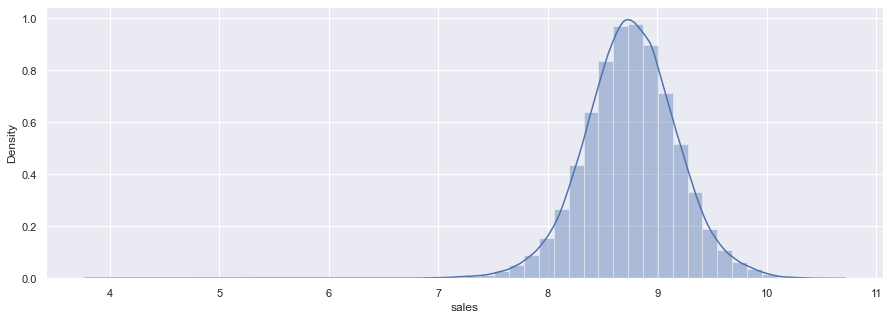

In [67]:
sns.distplot(df5['sales']);

### 5.3.3 Transformação de Natureza

In [68]:
# Aplicando método de encoding para períodos cíclicos

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [69]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 SELEÇÃO DE VARIÁVEIS

In [70]:
df6 = df5.copy()

## 6.1 Dividir dataframe em treino e test (dataset)

In [71]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [72]:
cols_drop = ['week_of_year', 'day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [73]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [74]:
# dataset treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# dataset test
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date : {}'.format(X_train['date'].min()))
print('Training Max Date : {}'.format(X_train['date'].max()))

print('\nTest Min Date : {}'.format(X_test['date'].min()))
print('Test Max Date : {}'.format(X_test['date'].max()))

Training Min Date : 2013-01-01 00:00:00
Training Max Date : 2015-06-18 00:00:00

Test Min Date : 2015-06-19 00:00:00
Test Max Date : 2015-07-31 00:00:00


## 6.2 Boruta como feature selector

In [76]:
# Dataset de treino para o boruta
# Dropando as colunas date e sales pois são dados de treino
X_train_n = X_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Definindo RandomForestRegressor
# Paramentro de n_jobs=-1 o algoritmo cria todas as árvores em paralelo e cria mais rápido o modelo
rf = RandomForestRegressor(n_jobs=-1)

# Definindo o boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Melhores features do boruta

In [77]:
# Método support do boruta apresenta o rank de relevância das variáveis para construção do modelo
cols_selected = boruta.support_.tolist()

# Melhores features selecionada pelo boruta
X_train_fs = X_train.drop(['date','sales'],axis=1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# Features não selecionadas pelo boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [78]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [79]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3 Seleção de variáveis manuais

In [80]:
cols_selected_boruta = ['store', 'promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year', 'promo2',
                        'promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos',
                        'day_sin','day_cos','week_of_year_sin','week_of_year_cos']

# Colunas para adicionar
feat_to_add = ['date','sales']


# features finais
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [81]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 MODELOS DE MACHINE LEARNING

In [82]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# preparação dos dados Séries Temporais
x_training = X_train[cols_selected_boruta_full]

## 7.1 Modelo de Média

In [83]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
# retornando a transformação da variável resposta quando foi realizada a transformação (log) da variável na etapa 5.3.2 Transformação da Variável Resposta. 
# método np.expm1 do numpy
baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Modelo de Regressão Linear

In [84]:
# model
lr = LinearRegression().fit(x_train,y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Modelo de Regressão Linear - Cross Validation

In [85]:
lr_result_cv = cross_validation(x_training, 5 ,'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Modelo de Regressão Linear Regularizada - Lasso

In [86]:
# model
lrr = Lasso(alpha=0.01).fit(x_train,y_train )


# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [87]:
lrr_result_cv = cross_validation(x_training, 5 ,'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regression

In [88]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Random Forest Regression - Cross Validation

In [89]:
rf_result_cv = cross_validation(x_training, 5 ,'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5 XGBoost Regression

In [90]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)


# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,857.809468,0.125117,1260.20886


### 7.5.1 XGBoost Regression - Cross Validation

In [91]:
xgb_result_cv = cross_validation(x_training, 5 ,'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1039.91 +/- 186.68,0.14 +/- 0.02,1496.16 +/- 258.53


## 7.6 Comparando a Performance dos Modelos

### 7.6.1 Performance Única

In [92]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,857.809468,0.125117,1260.208860
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Performance Real - Cross Validation

In [93]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1039.91 +/- 186.68,0.14 +/- 0.02,1496.16 +/- 258.53


# 8.0 AJUSTE FINO DE HIPERPARÂMETROS

## 8.1 Random Search

In [106]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree':[0.3, 0.7, 0.9],
    'min_child_weight':[3, 8, 15]
        }

MAX_EVAL = 5

In [107]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # escolhe o valores para os parâmetros aleatoriamente
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])


    # performance
    result = cross_validation(x_training, 5,'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

final_result

## 8.2 Modelo Final

In [108]:
param_tuned = {
    'n_estimators':3500,
    'eta':0.03,
    'max_depth':5,
    'subsample': 0.7,
    'colsample_bytree':0.9,
    'min_child_weight':8
}

In [109]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators=param_tuned['n_estimators'],
                                 eta=param_tuned['eta'],
                                 max_depth=param_tuned['max_depth'],
                                 subsample=param_tuned['subsample'],
                                 colsample_bytree=param_tuned['colsample_bytree'],
                                 min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)



# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

In [110]:
pickle.dump(model_xgb_tuned,open('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/dsproducao/webapp/Model/model_rossmann.pkl','wb'))

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [111]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales']=np.expm1(df9['sales'])
df9['predictions']=np.expm1(yhat_xgb_tuned)

## 9.1 Performance de Negócio

In [112]:
# soma as predições
df91=df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Fusão
df9_aux3 = pd.merge(df9_aux1,df9_aux2, how='inner', on='store' )
df92 = pd.merge(df91, df9_aux3, how='inner', on= 'store')

# Cenários
df92['worst_scenario'] = df92['predictions']-df92['MAE']
df92['best_scenario'] = df92['predictions']+df92['MAE']

# Ordenando as colunas
df92 = df92[['store', 'predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [113]:
df92.sort_values('MAPE', ascending = False).head()

In [114]:
sns.scatterplot(x='store', y='MAPE',data = df92)

In [115]:
df92.sample(4)

## 9.2 Performance Total

In [116]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

## 9.3 Performance de Machine Learning

In [117]:
df9['error'] = df9['sales']-df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']#

In [118]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9, label='SALES')
plt.axhline(1, linestyle= '--' )

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0 IMPLANTAÇÃO DO MODELO EM PRODUÇÃO

In [105]:
# Modelo treinado salvo
pickle.dump(model_xgb_tuned, open('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/dsproducao/webapp/Model/model_rossmann.pkl', 'wb'))

## 10.1 Classe Rossmann

In [95]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler = pickle.load(open ('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open ('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open ('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open ('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/parameter/store_type_scaler.pkl', 'rb')) 
                
        
        
    def data_cleaning(self, df1): 
    
    
        ## 1.1 Renomear as colunas

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
                    'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase,cols_old))

        # rename
        df1.columns = cols_new

        ## 1.3 Tipo de dados 

        # Transformar a data de object para date
        df1['date'] = pd.to_datetime( df1['date'] )

        
        ## 1.5 Preencher valores ausentes

        # Preencher os valores NAs - Para preenchimento dos valores ausentes foi tratada cada coluna de forma independente, foram 
        # consideradas algumas premissas, levando sempre em consideração o entendimento do negócio.

        # competition_distance   
        
        df1['competition_distance'] = df1['competition_distance'].values.astype('int64')
        
        # verificando a máxima distancia até o competidor mais próximo
        
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

        # competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year     
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year               
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval

        month_map = {1:'Jan', 2:'Feb', 3:'Mar',4:'Apr',5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0 , axis = 1)


        ## 1.6 Alterar tipos de dados  
        
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engineering(self, df2):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


        # competition since
        df2['competition_since']= df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1','%Y-%W-%w' )-datetime.timedelta( days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x =='b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0 FILTRAGEM DE VARIÁVEIS

        ## 3.1 Filtragem das linhas

        # Na etapa de filtragem de variáveis são consideradas as restrições de acordo com o negócio
        df2 = df2[df2['open'] != 0]
                  
        ## 3.2 Seleção das colunas

        # Na etapa de seleção de variáveis, são consideradas as variáveis mais relevantes ao modelo.
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2 
    

    def data_preparation(self, df5):
    
        ## 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)


        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)
        
        
        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)

        ## 5.3 Transformação

        ### 5.3.1 Encoding

        # state_holiday - Utilizado o One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Utilizado o Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Utilizado o Ordinal Encoding
        assortment_dict= {'basic':1,'extra':2,'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Transformação de Natureza

        # Aplicando método de encoding para períodos cíclicos

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected = ['store', 'promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year', 'promo2',
                         'promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos',
                         'day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        
        # prediction
        pred = model.predict(test_data)
        
        # unir a pred aos dados originais
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')        

## 10.2 API Handler

In [1]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# carregando model
model = pickle.load(open('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/dsproducao/webapp/Model/model_rossmann.pkl','rb'))

# Inicializa API
app = Flask (__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # existe dados
        if isinstance(test_json, dict): # exemplo único
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # múltiplos exemplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instanciar a classe Rossmann
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    

if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run('127.0.0.1', port=5000, debug=True)

## 10.3 API Tester

In [97]:
import requests

In [98]:
# Carregando o dataset de Test
df10 = pd.read_csv('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/dsproducao/Datasets/test.csv',low_memory=False)
df_store_raw = pd.read_csv('C:/Users/chris/Documents/Tech/ComunidadeDS/repos/03_ds_em_producao/dsproducao/Datasets/store.csv',low_memory=False)

In [99]:
# União do Dataset Test + Store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Escolha de loja para realizar a predição
df_test = df_test[df_test['Store'].isin([20,23,22])]

# Remover dias em que as loja está fechada
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [100]:
# Converter o Dataframe para arquivo json
data = json.dumps(df_test.to_dict(orient='records'))

In [101]:
# Chamada a API
# url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-model-test-ck.herokuapp.com/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code{}'.format(r.status_code))

Status Code200


In [102]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [103]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'], d2.loc[i,'prediction']))

Store Number 20 will sell R$335,881.20 in the next 6 weeks
Store Number 22 will sell R$181,079.70 in the next 6 weeks
Store Number 23 will sell R$252,511.96 in the next 6 weeks
